Data Loading

In [1]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [2]:
total_characters = len(text_data)

print("Characters:", total_characters)


Characters: 20479


Tokenizer

In [3]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [4]:
total_tokens = len(tokenizer.encode(text_data))

print("Tokens:", total_tokens)

Tokens: 5145


Data Loader

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):
    
    # Create dataset
    dataset = GPTDatasetV1(txt, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    
    "context_length": 256,  
    "embedding_dim": 768,    
    "n_heads": 12,          
    "n_layers": 12,         
    "dropout": 0.1,         
}

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [7]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [8]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [9]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


GPT MODEL

In [10]:
import torch.nn as nn
class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, dropout, num_heads, context_length):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_querys = nn.Linear(d_in, d_out, bias=False)
        self.W_keys = nn.Linear(d_in, d_out, bias=False)
        self.W_values = nn.Linear(d_in, d_out, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.linear_projection = nn.Linear(d_out, d_out)
        
        # Causal mask for autoregressive processing
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, inputs):
        batch, num_tokens, dim = inputs.shape
        query = self.W_querys(inputs)
        key = self.W_keys(inputs)
        value = self.W_values(inputs)

        query = query.view(batch, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        # Apply causal mask
        mask_bool = self.mask[:num_tokens, :num_tokens].bool()
        attn_scores.masked_fill_(mask_bool, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = torch.matmul(attn_weights, value)
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch, num_tokens, -1)
        return self.linear_projection(context_vec)

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config['embedding_dim'], config['embedding_dim'] * 4),
            GELU(),
            nn.Linear(config['embedding_dim'] * 4, config['embedding_dim'])
        )

    def forward(self, inputs):
        return self.layers(inputs)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, inputs):
        mean = inputs.mean(dim=-1, keepdim=True)
        var = inputs.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (inputs - mean) / torch.sqrt(var + self.eps)
        return norm_x * self.scale + self.shift

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiheadAttention(
            d_in=config['embedding_dim'], 
            d_out=config['embedding_dim'], 
            dropout=config['dropout'], 
            num_heads=config['n_heads'], 
            context_length=config['context_length']
        )
        self.norm1 = LayerNorm(config["embedding_dim"])
        self.norm2 = LayerNorm(config["embedding_dim"])
        self.ff = FeedForward(config)
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, inputs):
        add_connection = inputs
        output = self.norm1(inputs)
        output = self.attention(output)
        output = self.dropout(output)
        output = output + add_connection
        
        add_connection = output
        output = self.norm2(output)
        output = self.ff(output)
        output = self.dropout(output)
        output = output + add_connection
        
        return output

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embedding = nn.Embedding(config['vocab_size'], config['embedding_dim'])
        self.pos_embedding = nn.Embedding(config['context_length'], config['embedding_dim'])
        self.dropout = nn.Dropout(config['dropout'])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(config) for _ in range(config["n_layers"])])
        self.out_head = nn.Linear(config["embedding_dim"], config["vocab_size"], bias=False)
        self.final_norm = LayerNorm(config["embedding_dim"])

    def forward(self, inputs):
        batch_size, seq_len = inputs.shape
        tok_embeds = self.token_embedding(inputs)
        pos_embeds = self.pos_embedding(torch.arange(seq_len, device=inputs.device))
        
        x = tok_embeds + pos_embeds
        x = self.dropout(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [11]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    

    for step in range(max_new_tokens):  # Loop to generate tokens
        #print(f"Step {step + 1}: Generating new token...\n")

        # 1. **Trim the input context** (model only supports a fixed length)
        idx_cond = idx[:, -context_size:]
        #print(f"Context tokens (last {context_size} tokens):\n{idx_cond}\n")
        
        # 2. **Pass the context into the model to get predictions**
        with torch.no_grad():  # Disable gradients for efficiency
            logits = model(idx_cond)
        
        #print(f"Logits shape (Batch x Tokens x Vocab Size): {logits.shape}\n")
        
        # 3. **Extract only the last token's logits**
        logits = logits[:, -1, :]  # Shape becomes (batch, vocab_size)
        #print(f"Logits for the last predicted token:\n{logits}\n")

        # 4. **Convert logits to probabilities using softmax**
        probas = torch.softmax(logits, dim=-1)
        #print(f"Probabilities after softmax:\n{probas}\n")

        # 5. **Choose the most probable next token**
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # Shape: (batch, 1)
        #print(f"Predicted next token index:\n{idx_next}\n")

        # 6. **Append the predicted token to the sequence**
        idx = torch.cat((idx, idx_next), dim=1)  # Shape: (batch, n_tokens + 1)
        #print(f"Updated sequence:\n{idx}\n")
        #print("-" * 50)  # Separator for readability

    #print("\nFinal generated sequence:")
    #print(idx)
    return idx

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1
            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


In [12]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPT(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

In [13]:
model

GPT(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (W_querys): Linear(in_features=768, out_features=768, bias=False)
        (W_keys): Linear(in_features=768, out_features=768, bias=False)
        (W_values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiheadAttention(
        (W_

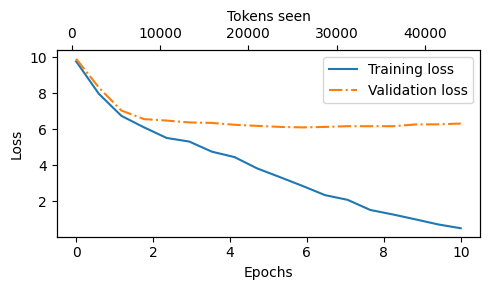

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)).tolist()
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [15]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you get to work.

I turned--as the end one says half


In [16]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted


In [17]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you in spiteace," that robbed felt my picture ' by dep handsome, and


In [18]:
model

GPT(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (W_querys): Linear(in_features=768, out_features=768, bias=False)
        (W_keys): Linear(in_features=768, out_features=768, bias=False)
        (W_values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiheadAttention(
        (W_

In [19]:
torch.save(model.state_dict(), "model.pth")

In [20]:
model1 = GPT(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model1.eval()


GPT(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (W_querys): Linear(in_features=768, out_features=768, bias=False)
        (W_keys): Linear(in_features=768, out_features=768, bias=False)
        (W_values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiheadAttention(
        (W_

In [21]:
token_ids = generate(
    model=model1,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0.1
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted


In [22]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

Retrain the saved model

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model2= GPT(GPT_CONFIG_124M)
model2.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model2.train()

GPT(
  (token_embedding): Embedding(50257, 768)
  (pos_embedding): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (W_querys): Linear(in_features=768, out_features=768, bias=False)
        (W_keys): Linear(in_features=768, out_features=768, bias=False)
        (W_values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear_projection): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiheadAttention(
        (W_

: 

In [ ]:
num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    model2, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 0.378, Val loss 6.476
Ep 1 (Step 000005): Train loss 0.265, Val loss 6.511
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Ep 2 (Step 000010): Train loss 0.199, Val loss 6.580
Ep 2 (Step 000015): Train loss 0.190, Val loss 6.665
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the secret, and were amusing himself by holding
Ep 3 (Step 000020): Train loss 0.136, Val loss 6.686
Ep 3 (Step 000025): Train loss 0.114, Val loss 6.761
Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back the window-curtains, moved aside a _jardiniere_ full of
Ep 4 (Step 000030): Train loss 0.118, Val loss 6.807
Ep 4 (S